In [7]:
	
%load_ext autoreload
%autoreload 2
import numpy  as np
import pandas as pd

from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from common import viz
from common import hallmark as hm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
def getdist(path, dist):
    df = pd.read_csv(path, sep='\t')
    return df[dist].values

pf = hm.ParaFrame('cache/SPO2023/summ/{NGC}_a{aspin:g}_i{inc:g}_{freq}.tsv')

for k in set(pf.keys()) - {'path'}:
    globals()[k] = np.unique(pf[k])
    print(k, globals()[k][:16])

freq = ['86.e9', '230.e9', '345.e9']
cols = ['time', 'Mdot', 'Ftot', 'alpha0', 'beta0', 'major_FWHM', 'minor_FWHM', 'PA', 'mnet', 'vnet', 'mavg', 'vavg', 'beta_2_amplitude', 'beta_2_phase', 'tauI', 'tauF'] 

NGC ['NGC3998' 'NGC4261' 'NGC4594']
freq ['230.e9' '345.e9' '86.e9']
inc [ 50. 160.]
aspin [-0.94 -0.5   0.    0.5   0.94]


In [3]:
df = pd.read_csv(sel.path.iloc[0], sep='\t')
df.columns

NameError: name 'sel' is not defined

In [ ]:
def corr_table(df):
    corr = np.empty((len(cols), len(cols)))
    pvalue = np.empty((len(cols), len(cols)))
    relation = np.empty((len(cols), len(cols)))

    for r in cols:
        for c in cols:
            corr_value, p_value = pearsonr(df[r], df[c])
            corr[cols.index(r)][cols.index(c)] = round(corr_value, 4)
            if p_value > 0.05:
                p_value = 1
                relation[cols.index(r)][cols.index(c)] = round(corr_value, 4)
            else:
                relation[cols.index(r)][cols.index(c)] = round(corr_value, 4)
            pvalue[cols.index(r)][cols.index(c)] = round(p_value, 4)

    corr = pd.DataFrame(corr, columns=cols, index=cols)
    pvalue = pd.DataFrame(pvalue, columns=cols, index=cols)
    relation = pd.DataFrame(relation, columns=cols, index=cols)
    return corr, pvalue, relation

/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask |= self[k] == v
/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask |= self[k] == v
/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a

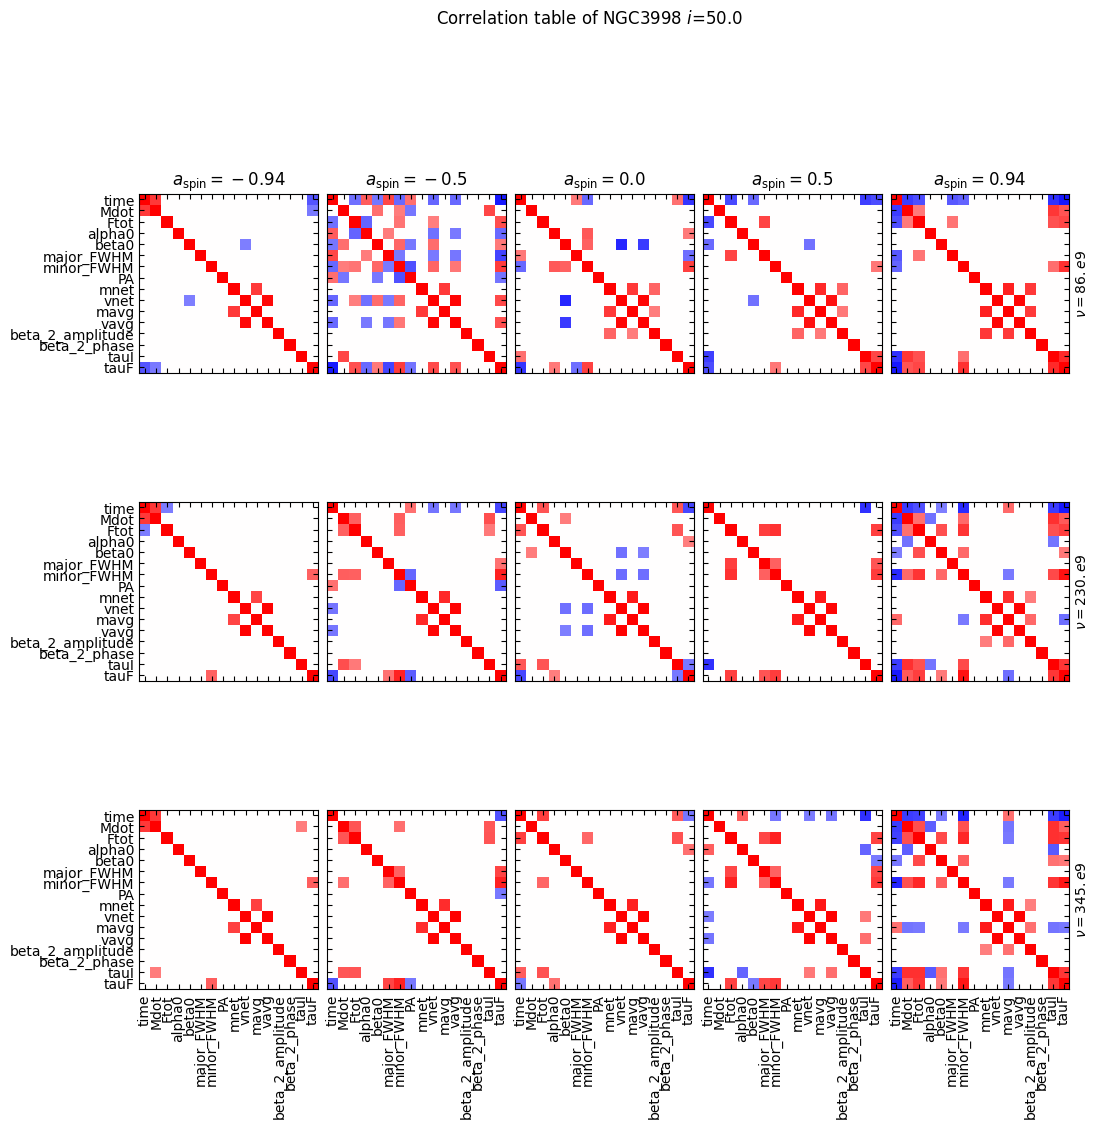

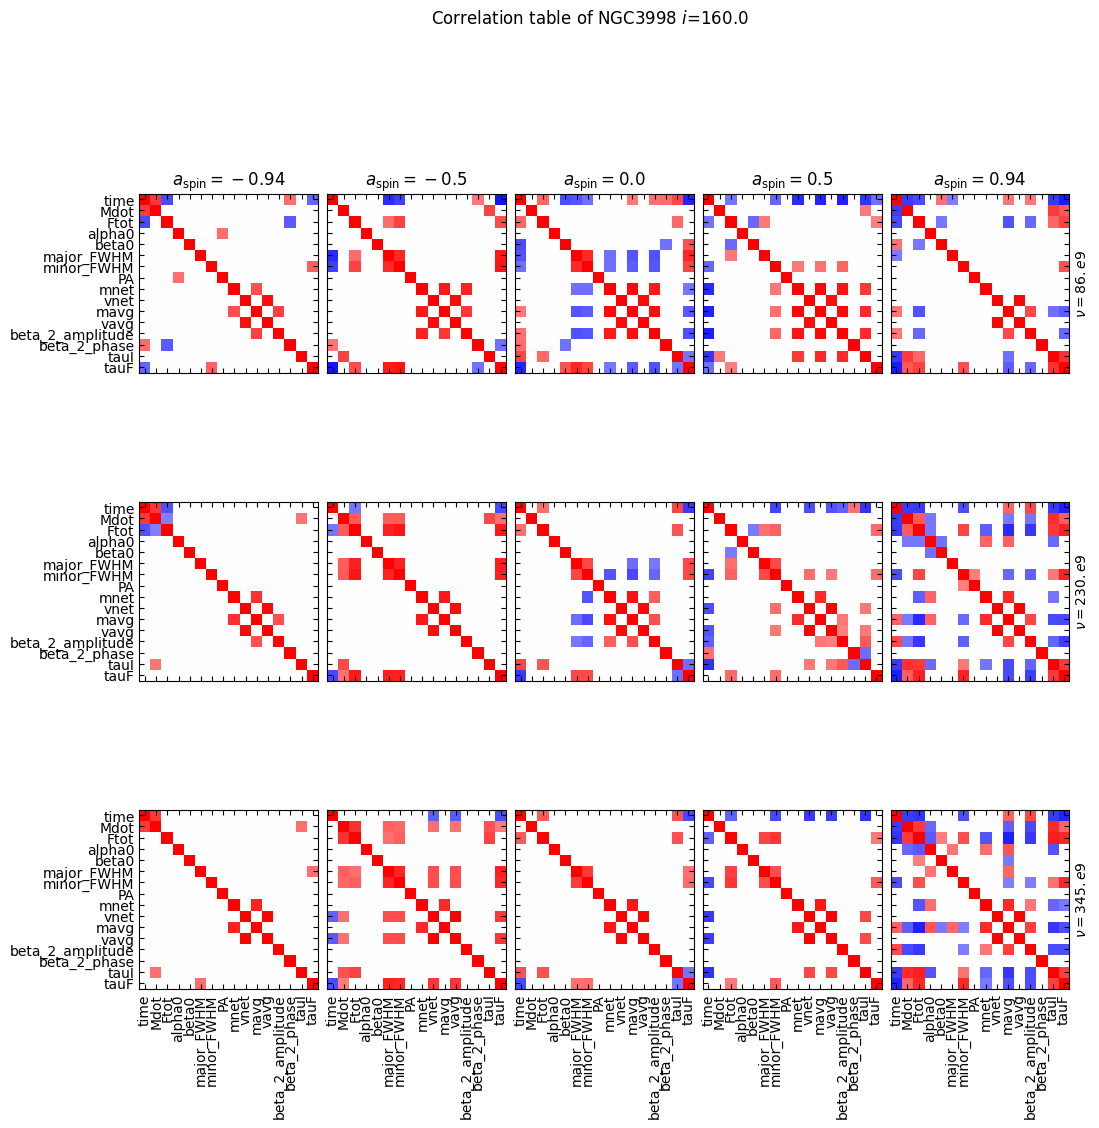

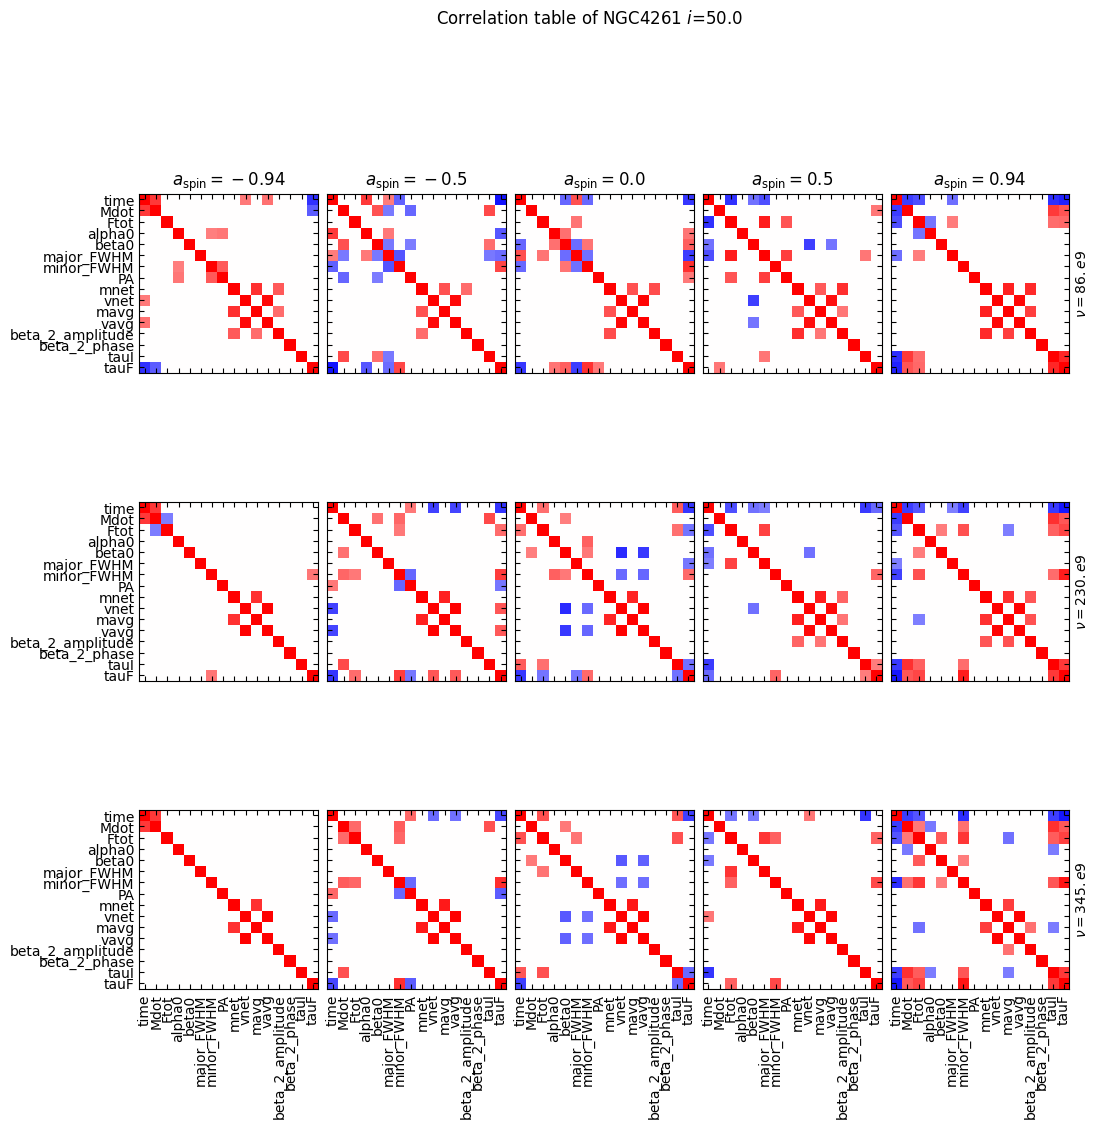

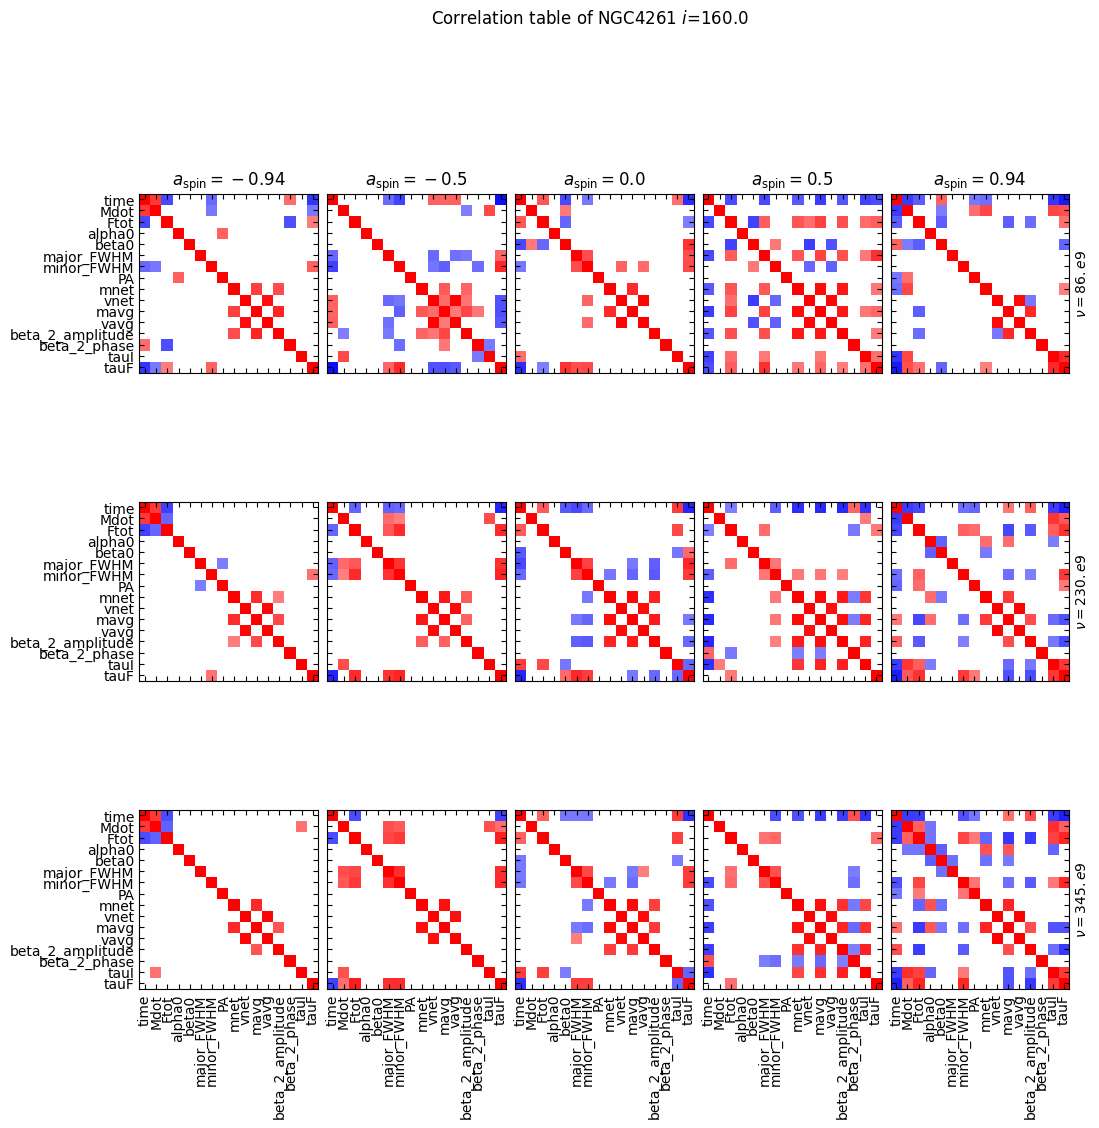

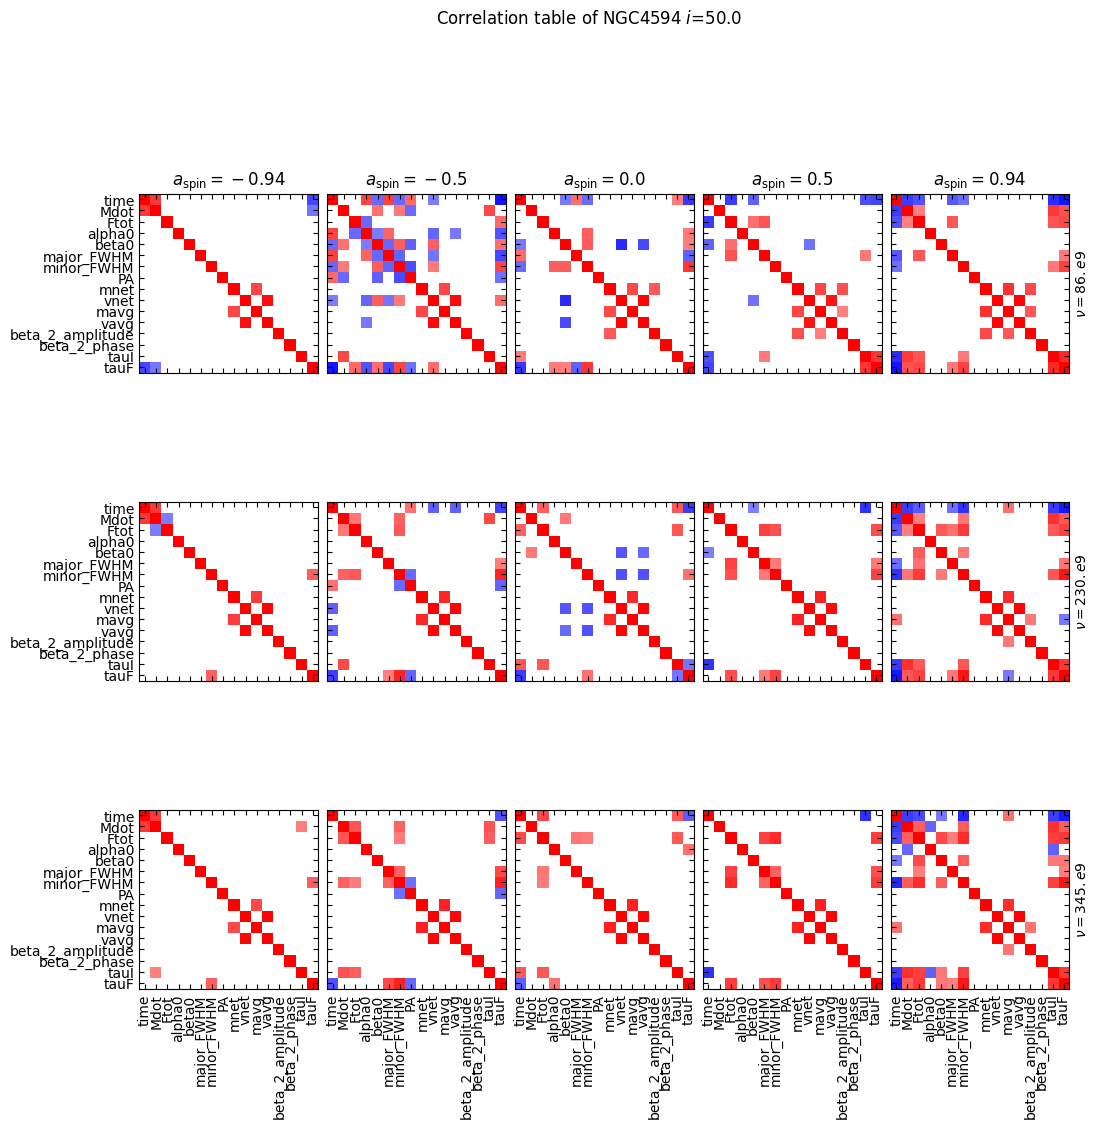

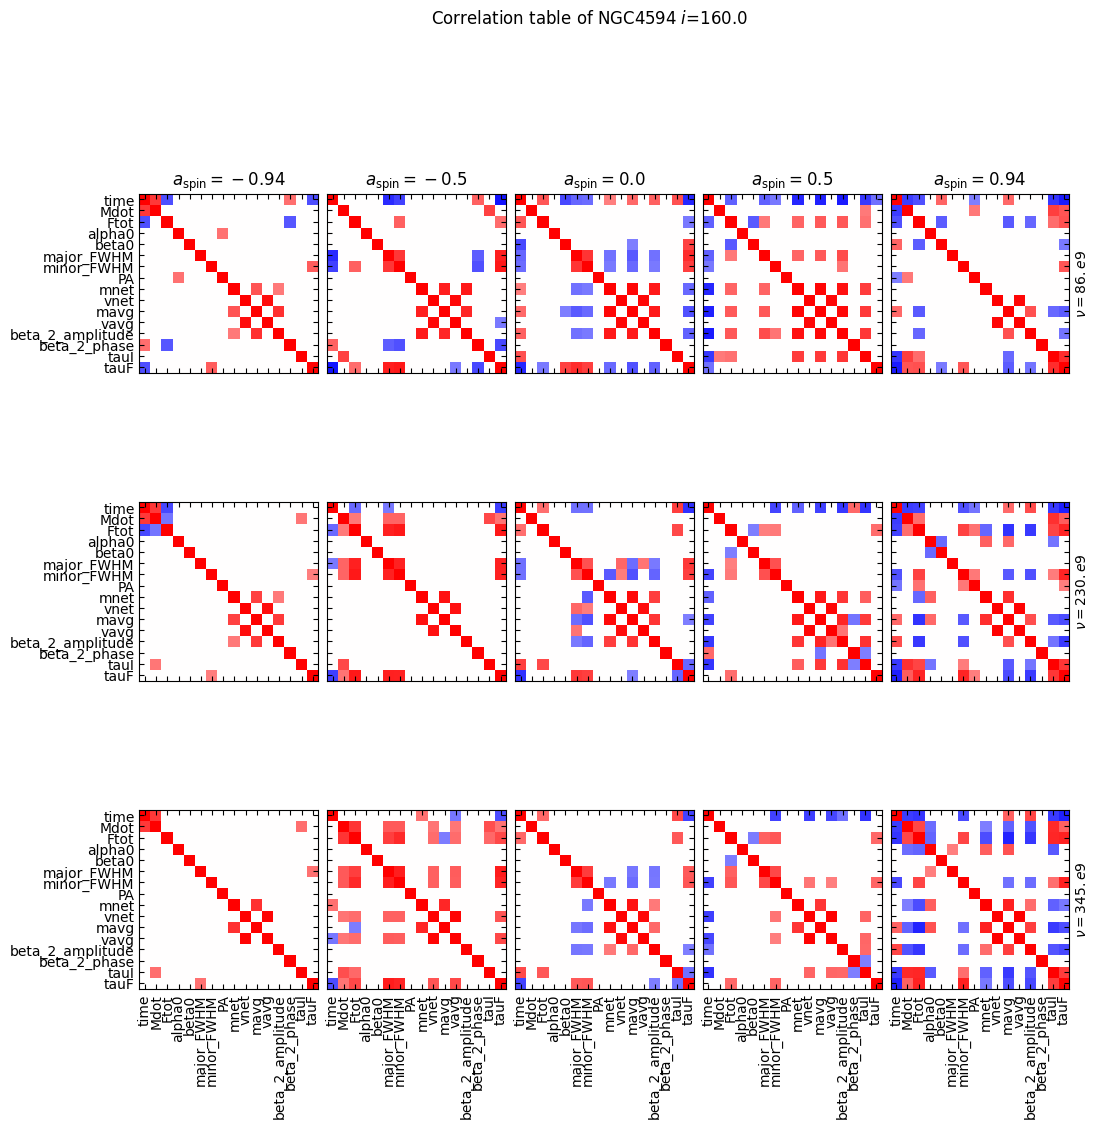

In [91]:
from common import viz
def plot(ax, pf):
    df = pd.read_csv(pf.path.iloc[0], sep='\t')
    corr = df[cols].corr()

    # Filter the corr to find pattern more easily
    for col in corr.columns:
        corr[col] = np.where(abs(corr[col])<0.5, 0, corr[col]) 

    # Plot graph
    ax.imshow(corr, vmin=-1, vmax=1, cmap='bwr')

    # Formatting
    ax.set_yticks(range(len(cols)), cols)
    ax.set_xticks(range(len(cols)), cols, rotation='vertical')


for obj in NGC:
    for i in inc:
        viz.grid(pf(NGC=obj)(inc=i), plot, aspin=aspin, freq=freq,
                 title=f'Correlation table of {obj} $i$={i}', figsize=(12,12),
                 xtitle=r'$a_\mathrm{{spin}}={}$',  ytitle=r'$\nu={}$',)

50.0


/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask |= self[k] == v
/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask |= self[k] == v
/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a

160.0


/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask |= self[k] == v
/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask |= self[k] == v
/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a

50.0


/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask |= self[k] == v
/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask |= self[k] == v
/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a

160.0


/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask |= self[k] == v
/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask |= self[k] == v
/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a

50.0


/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask |= self[k] == v
/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask |= self[k] == v
/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a

160.0


/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask |= self[k] == v
/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask |= self[k] == v
/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a

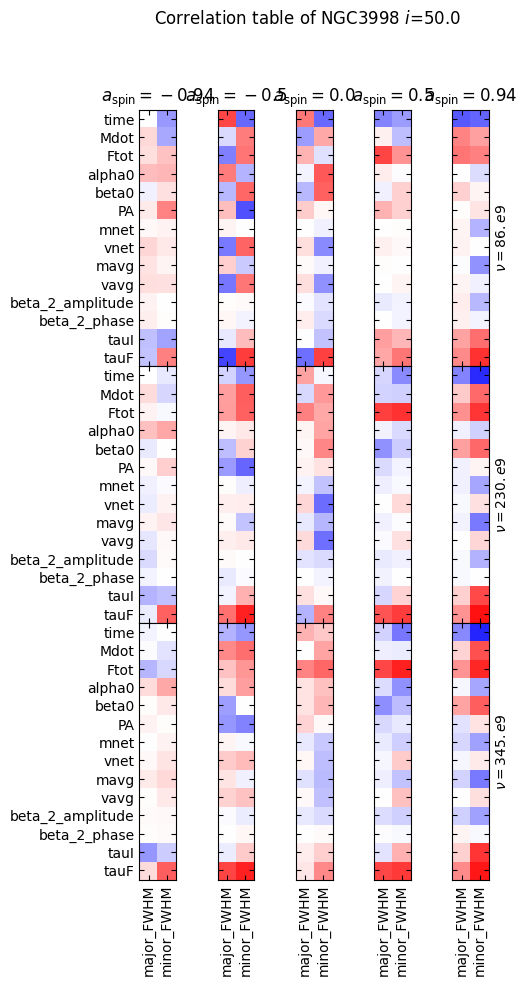

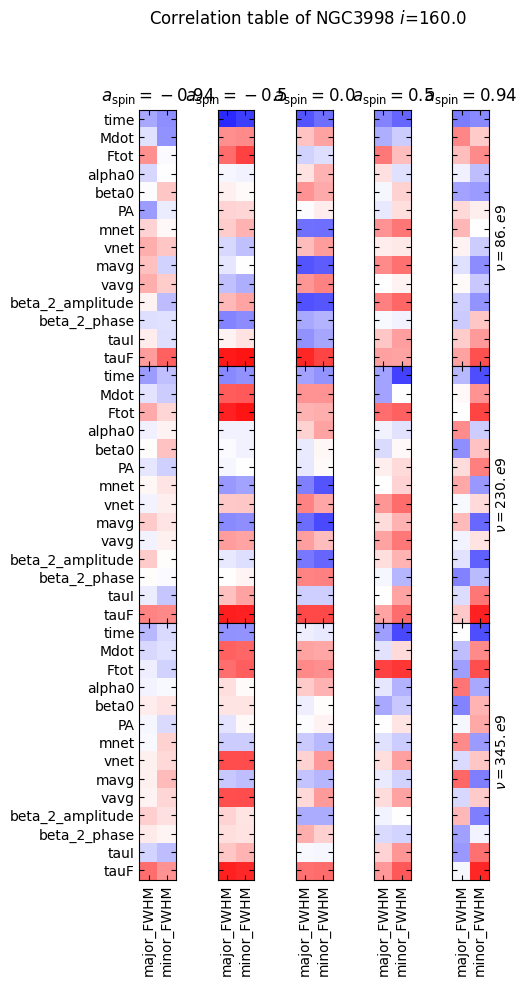

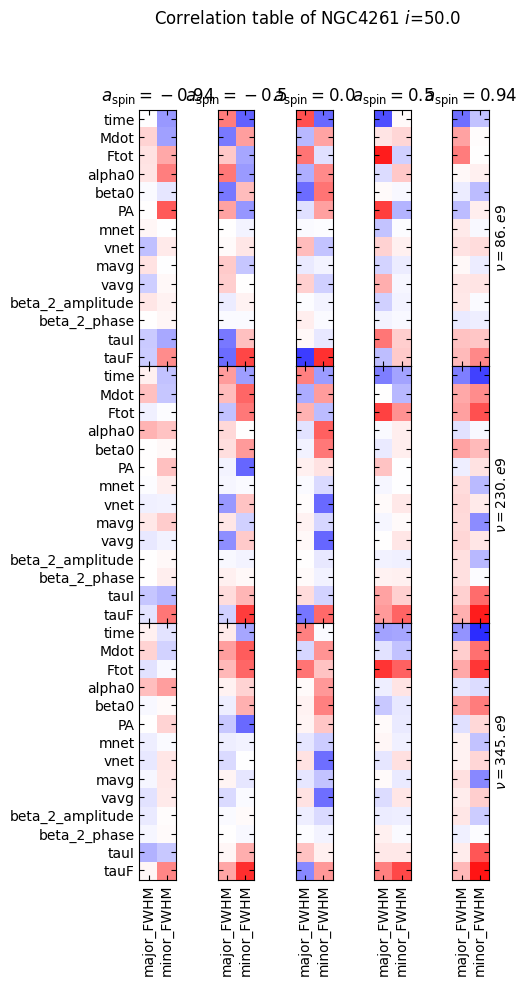

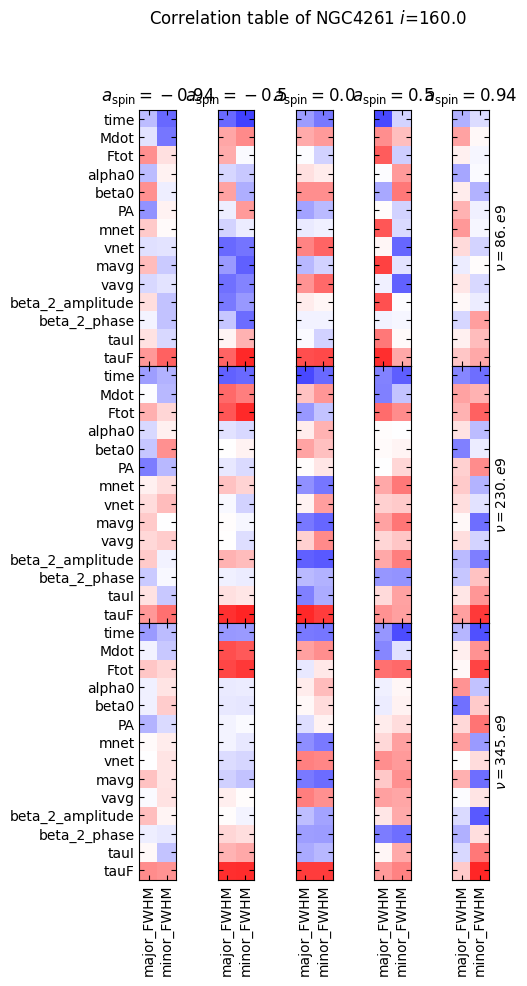

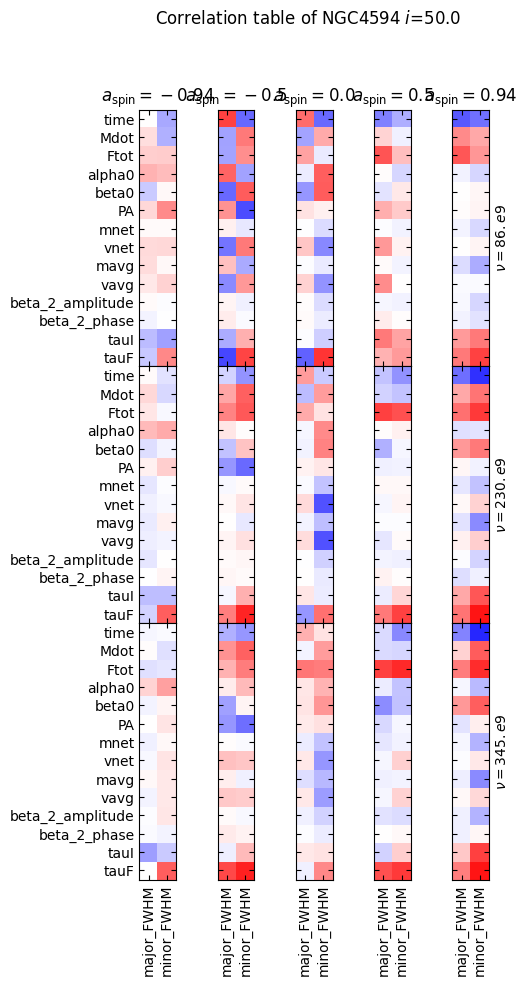

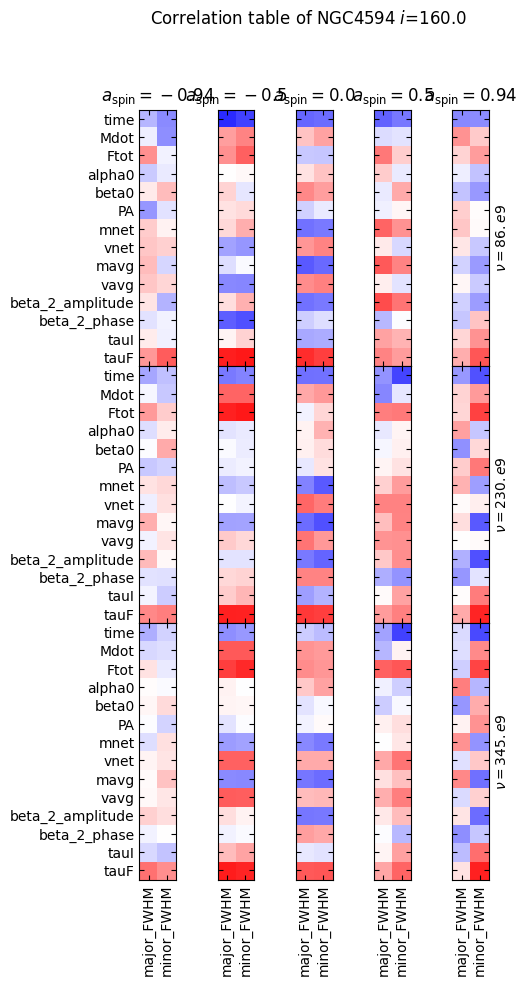

In [55]:
def FWHM_corr(ax, pf):
    items = ['major_FWHM', 'minor_FWHM']
    df = pd.read_csv(pf.path.iloc[0], sep='\t')

    # Show only corrleation between Major/Minor FWHM and other variables
    new_cols = ['time', 'Mdot', 'Ftot', 'alpha0', 'beta0', 'major_FWHM', 'minor_FWHM', 'PA', 'mnet', 'vnet', 'mavg', 'vavg', 'beta_2_amplitude', 'beta_2_phase', 'tauI', 'tauF'] 
    corr = df[new_cols].corr()
    for item in items:
        new_cols.remove(item)
    FWHM_corr = corr[items].drop(items)

    # Filter the corr to find pattern more easily
    #for col in FWHM_corr.columns:
    #    FWHM_corr[abs(FWHM_corr[col]) < 0.5] = 0

    ax.imshow(FWHM_corr, vmin=-1, vmax=1, cmap='bwr')
    
    ax.set_yticks(range(len(new_cols)), new_cols)
    ax.set_xticks(range(2), ['major_FWHM', 'minor_FWHM'], rotation='vertical')

for obj in NGC:
    for i in inc:
        print(i)
        fig = viz.grid(pf(NGC=obj)(inc=i), FWHM_corr, aspin=aspin, freq=freq,
                 title=f'Correlation table of {obj} $i$={i}',
                 xtitle=r'$a_\mathrm{{spin}}={}$',  ytitle=r'$\nu={}$',
                 figsize=(5,10), fout=f'output/plot/corr/FWHM_corr/FWHM_corr_{obj}_{i}')

/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask |= self[k] == v
/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask |= self[k] == v
/var/folders/f5/93qk9czs7835g6z9_k6k6wvc0000gn/T/ipykernel_18629/2483641334.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result

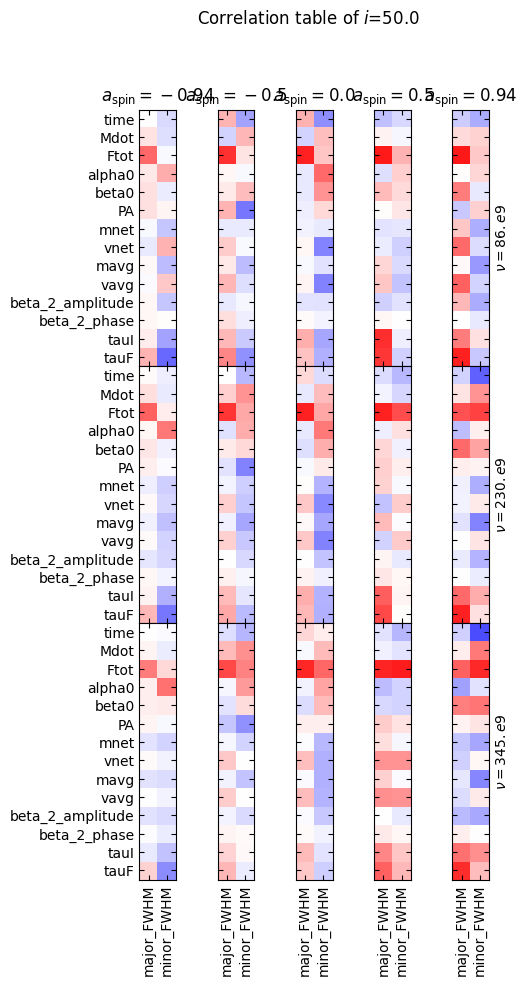

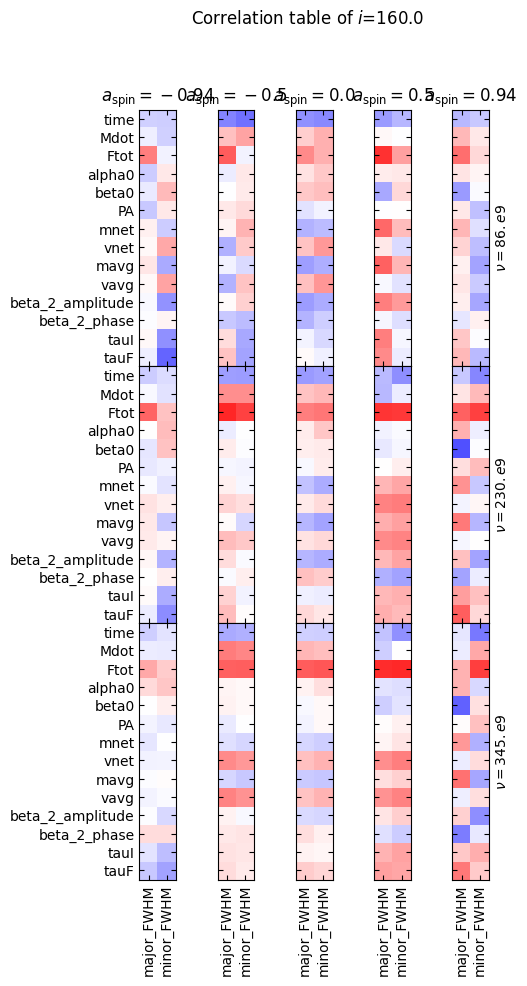

In [54]:
def FWHM_groupcorr(ax, pf):
    items = ['major_FWHM', 'minor_FWHM']
    new_cols = ['time', 'Mdot', 'Ftot', 'alpha0', 'beta0', 'major_FWHM', 'minor_FWHM', 'PA', 'mnet', 'vnet', 'mavg', 'vavg', 'beta_2_amplitude', 'beta_2_phase', 'tauI', 'tauF'] 
    df = pd.DataFrame(columns=new_cols)
 
    # Group the data from different NGC objects
    # To obtain a general relationship of corr
    for obj in NGC:
        tmp = pd.read_csv(pf(NGC=obj).path.iloc[0], sep='\t')
        df = pd.concat([df, tmp])
    corr = df[new_cols].corr()

    # Show only corrleation between Major/Minor FWHM and other variables
    for item in items:
        new_cols.remove(item)
    FWHM_corr = corr[items].drop(items)

    # Filter the corr to find pattern more easily
    #for col in FWHM_corr.columns:
    #    FWHM_corr[abs(FWHM_corr[col]) < 0.5] = 0

    # Plot graph
    ax.imshow(FWHM_corr, vmin=-1, vmax=1, cmap='bwr')
    
    # Plot Formatting
    ax.set_yticks(range(len(new_cols)), new_cols)
    ax.set_xticks(range(2), ['major_FWHM', 'minor_FWHM'], rotation='vertical')

def groupcorr(ax, pf):
    df = pd.DataFrame(columns=new_cols)
 
    # Group the data from different NGC objects
    # To obtain a general relationship of corr
    for obj in NGC:
        tmp = pd.read_csv(pf(NGC=obj).path.iloc[0], sep='\t')
        df = pd.concat([df, tmp])
    corr = df[new_cols].corr()

    # Filter the corr to find pattern more easily
    for col in corr.columns:
        corr[col] = np.where(abs(corr[col])<0.5, 0, corr[col]) 

    # Plot graph
    ax.imshow(corr, vmin=-1, vmax=1, cmap='bwr')

    # Formatting
    ax.set_yticks(range(len(cols)), cols)
    ax.set_xticks(range(len(cols)), cols, rotation='vertical')

if True:
    for i in inc:
        fig = viz.grid(pf(inc=i), FWHM_groupcorr, aspin=aspin, freq=freq,
                 title=f'Correlation table of $i$={i}',
                 xtitle=r'$a_\mathrm{{spin}}={}$',  ytitle=r'$\nu={}$',
                 figsize=(5,10), fout=f'output/plot/corr/FWHM_corr/FWHM_groupcorr_{i}')

In [51]:
NGC

array(['NGC3998', 'NGC4261', 'NGC4594'], dtype=object)